In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas_profiling import ProfileReport
import lmdiag

/usr/local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%matplotlib inline

In [3]:
TRAIN_PATH = "/workspace/data/house_prices/train.csv"

train_df = pd.read_csv(TRAIN_PATH)
# columns=["Id", "OverallQual", "GrLivArea", "TotalBsmtSF", "FullBath", "GarageArea", "SalePrice"]
# train_df = train_df[columns]

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA後の対応

In [5]:
Outlier_id_list = [524, 1299]
train_df = train_df.query("Id not in @Outlier_id_list").copy()

In [6]:
columns_list = ["GrLivArea", "SalePrice"]

for x in columns_list:
    train_df[x] = train_df[x].apply(lambda x: np.log(x))

# GLM

## ポアソン回帰

In [7]:
columns = list(train_df.columns)

x = train_df.drop("SalePrice", axis=1).copy()
y = train_df[['SalePrice']]

In [8]:
data = pd.concat([x, y], axis=1)

In [9]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [10]:
train_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [11]:
form_list = [
    "SalePrice ~ OverallQual",
    "SalePrice ~ GrLivArea",
    "SalePrice ~ OverallQual + GrLivArea",
    "SalePrice ~ OverallQual + GrLivArea + TotalBsmtSF",
    "SalePrice ~ OverallQual + GrLivArea + TotalBsmtSF + FullBath",
    "SalePrice ~ OverallQual + GrLivArea + TotalBsmtSF + FullBath + GarageArea"
]

for form in form_list:
    # 線形予測子
    formula = form

    #リンク関数
    link = sm.genmod.families.links.log

    # 誤差関数
    family = sm.families.Poisson()

    mod = smf.glm(formula=formula, data=data, family=family)
    result = mod.fit() 
    # print(result.summary())
    print(round(result.aic))

6335
6338
6336
6337
6339
6340


In [16]:
# 線形予測子
formula = "SalePrice ~ OverallQual + GrLivArea"

#リンク関数
link = sm.genmod.families.links.log

# 誤差関数
family = sm.families.Poisson()

mod = smf.glm(formula=formula, data=data, family=family)
result = mod.fit() 
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1458
Model:                            GLM   Df Residuals:                     1455
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3164.8
Date:                Tue, 01 Feb 2022   Deviance:                       4.5670
Time:                        17:32:04   Pearson chi2:                     4.55
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01009
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.1228      0.187     11.329      

In [17]:
from statsmodels.graphics.api import abline_plot

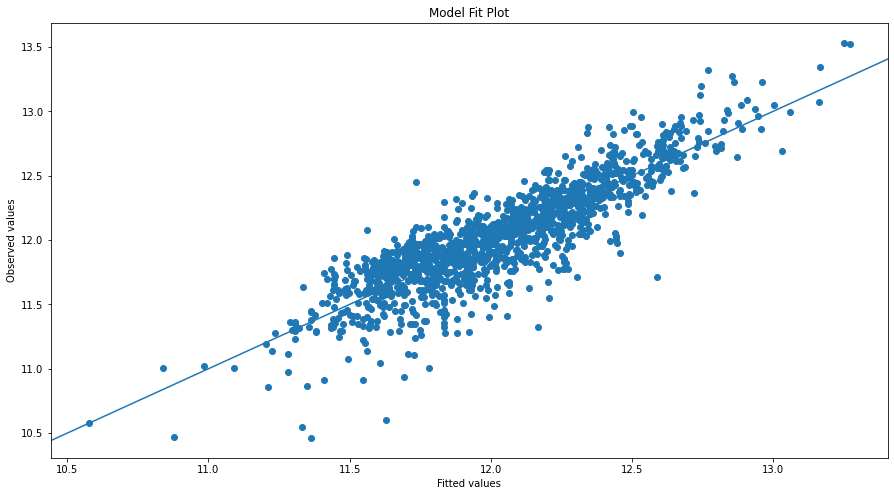

In [18]:
nobs = result.nobs
yhat = result.mu

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')

plt.show()

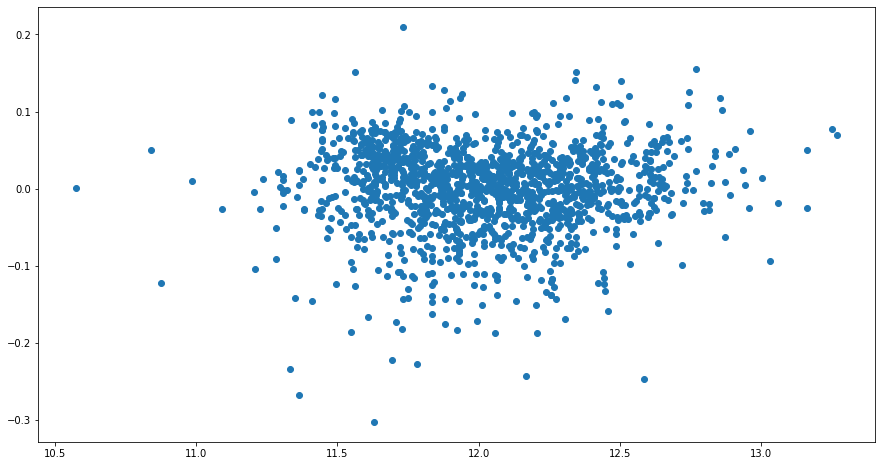

In [19]:
fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(yhat, result.resid_pearson)
# ax.hlines(0, 0, 1)
# ax.set_xlim(0, 1)

plt.show()

In [20]:
train_df['SalePrice'].describe()

count    1458.000000
mean       12.024009
std         0.399715
min        10.460242
25%        11.774713
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

In [21]:
0.4*0.4

0.16000000000000003